Model Ideas

Encoders:
- Attentation based encoder that includes edge weights, see https://arxiv.org/abs/1803.08475 and https://arxiv.org/abs/2006.07054 or use an EdgeGAT convolutional layer
- Message Passing that includes edge weights, see https://docs.dgl.ai/guide/training-eweight.html#guide-training-eweight
- GIN convolutional layer

Decoders:
- just beam search?
- RNN with masking
- just a fully connected decoder with some special loss?
- n x n output probabilities for each row -> argmax & cross entropy loss

In [234]:
import os
os.environ["DGLBACKEND"] = "pytorch"

import dgl
from dgl.dataloading import GraphDataLoader
import torch

from utils import BookDataset, load_dgl_graph, ATTR

In [235]:
# config
BATCH_SIZE = 1
EPOCHS = 10

In [236]:
# generate Cain's Jawbone graph
cains_jawbone_graph = load_dgl_graph("Cain's Jawbone")

# generate test graph
test_graph = load_dgl_graph("The Alchemist")

In [237]:
# load training dataset
dataset = BookDataset()
dataloader = GraphDataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("number of graphs in dataset:", len(dataset))

number of graphs in dataset: 270


In [238]:
# define GNN

from dgl.nn import GraphConv
from torch.nn import Module, GRU, Linear

class Encoder(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)

    def forward(self, graph):
        h = graph.ndata[ATTR]
        h = self.conv1(graph, h)
        h = torch.relu(h)
        h = self.conv2(graph, h)
        return h


class Decoder(torch.nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(Decoder, self).__init__()
        self.rnn = GRU(in_dim, h_dim, batch_first=True) # ???
        self.fc = Linear(h_dim, out_dim)

    def forward(self, graph):
        output, _ = self.rnn(graph)
        output = self.fc(output[-1])
        return output


class GNN(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(GNN, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, graph):
        encoded_graph = self.encoder(graph)
        output_sequence = self.decoder(encoded_graph)
        return output_sequence

In [31]:
import torch.nn.functional as F
import numpy as np

# train model
encoder = Encoder(3, 32)
decoder = Decoder(32, 32, 100)
model = GNN(encoder, decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses: list[float] = []
N = len(dataset)
model.train()
for epoch in range(EPOCHS):
    print(f"epoch {epoch+1:2}/{EPOCHS}", end=" ", flush=True)
    for graph, label in dataloader:
        pred = model(graph)
        loss = F.l1_loss(pred, label.flatten())
        losses.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("| average loss", np.mean(losses[epoch*N : (epoch+1)*N]), flush=True)

epoch  1/10 | average loss 35.654857133936
epoch  2/10 | average loss 26.403730343006277
epoch  3/10 | average loss 25.160837025112578
epoch  4/10 | average loss 24.992739507887098
epoch  5/10 | average loss 24.97010624497025
epoch  6/10 | average loss 24.96879214534053
epoch  7/10 | average loss 24.970303818031592
epoch  8/10 | average loss 24.966229212725604
epoch  9/10 | average loss 24.9655877078021
epoch 10/10 | average loss 24.9660370932685


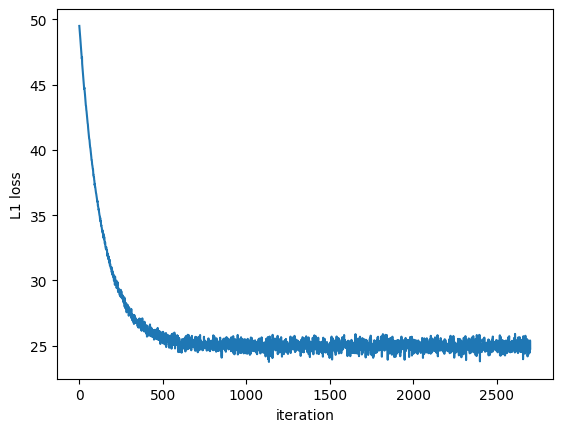

In [32]:
from matplotlib import pyplot as plt

plt.plot(range(len(losses)), losses)
plt.xlabel("iteration")
plt.ylabel("L1 loss")
plt.show()

In [33]:
model(test_graph)

tensor([52.4609, 50.8413, 50.0900, 54.0558, 52.7221, 51.6681, 45.3450, 51.5755,
        53.3538, 52.9872, 50.5524, 47.6117, 44.4633, 50.8524, 43.1352, 42.3877,
        43.2519, 43.1549, 54.8876, 44.9554, 45.5215, 50.1122, 46.9809, 47.7933,
        50.6142, 52.3843, 53.1873, 52.7543, 50.5943, 51.2885, 47.3579, 50.6045,
        47.3962, 54.5694, 55.1804, 53.8726, 48.1419, 54.5705, 52.8205, 45.8781,
        47.1536, 50.3197, 48.6535, 46.1151, 43.3680, 46.6679, 44.5827, 45.8537,
        49.2845, 53.4110, 49.8005, 53.4422, 49.0388, 47.3575, 50.8821, 50.0679,
        47.3519, 51.1579, 51.9387, 50.4062, 46.8735, 55.7091, 47.6670, 53.8732,
        50.9005, 50.6234, 46.9174, 53.2347, 52.0242, 48.1357, 54.1895, 54.5886,
        49.4320, 52.7421, 50.0861, 46.2733, 48.1008, 38.9976, 52.1231, 47.5226,
        54.4857, 47.5661, 46.4144, 47.8421, 45.2028, 51.6481, 52.8365, 49.3830,
        46.3553, 48.5815, 49.2805, 52.0584, 48.3732, 45.8524, 46.1681, 47.2618,
        53.7312, 48.5841, 49.0312, 49.46

In [241]:
from dgl.nn import EdgeGATConv

class Encoder(Module):
    def __init__(
        self,
        node_dim,
        edge_dim,
        out_dim,
    ):
        super(Encoder, self).__init__()
        self.conv = EdgeGATConv(node_dim, edge_dim, out_dim, num_heads=1)

    def forward(self, graph):
        h = graph.ndata[ATTR].float()
        e = graph.edata[ATTR].float().unsqueeze(1)

        h = self.conv(graph, h, e)
        h = torch.relu(h)

        return h.squeeze(1)

In [242]:
import torch.nn.functional as F
import numpy as np

# train model
encoder = Encoder(3, 1, 32)
decoder = Decoder(32, 32, 100)
model = GNN(encoder, decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses: list[float] = []
N = len(dataset)
model.train()
for epoch in range(EPOCHS):
    print(f"epoch {epoch+1:2}/{EPOCHS}", end=" ", flush=True)
    for graph, label in dataloader:
        pred = model(graph)
        loss = F.l1_loss(pred, label.flatten())
        losses.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("| average loss", np.mean(losses[epoch*N : (epoch+1)*N]), flush=True)

epoch  1/10 | average loss 34.861306275261775
epoch  2/10 | average loss 25.91825095989086
epoch  3/10 | average loss 25.06667303862395
epoch  4/10 | average loss 24.988832325405546
epoch  5/10 | average loss 24.98460674992314
epoch  6/10 | average loss 24.97833273852313
epoch  7/10 | average loss 24.97637058540627
epoch  8/10 | average loss 24.97724609375
epoch  9/10 | average loss 24.977199130588108
epoch 10/10 | average loss 24.977108065287272


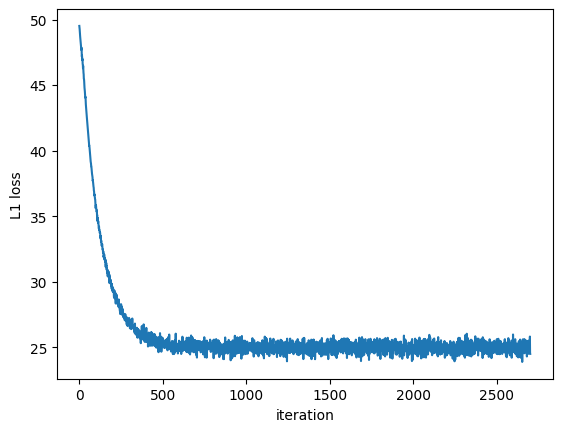

In [243]:
from matplotlib import pyplot as plt

plt.plot(range(len(losses)), losses)
plt.xlabel("iteration")
plt.ylabel("L1 loss")
plt.show()

In [244]:
model(test_graph)

tensor([52.2186, 51.2284, 49.0802, 53.3603, 52.8856, 51.6049, 46.2518, 51.0997,
        54.1512, 51.6254, 49.1824, 48.9065, 45.4849, 51.7172, 42.7291, 42.7410,
        44.6053, 41.9614, 54.9394, 44.9661, 46.5371, 48.9267, 46.5086, 46.6157,
        48.6586, 51.4569, 53.9036, 54.3837, 49.9309, 50.9372, 46.8219, 50.0466,
        48.1047, 54.1291, 55.7733, 53.6167, 48.1981, 52.6050, 52.8285, 45.6378,
        47.4173, 49.3500, 49.6206, 47.1890, 44.5101, 47.3097, 46.3907, 45.1906,
        50.3326, 53.2454, 51.1304, 52.3412, 48.5645, 47.1492, 52.0904, 49.1135,
        46.0177, 51.6748, 51.5068, 49.4862, 45.8718, 56.0367, 47.5422, 54.3236,
        52.0021, 52.0258, 46.7214, 51.4860, 51.4077, 48.4435, 54.6482, 55.0122,
        50.2606, 52.9027, 51.5695, 44.8478, 49.1141, 41.3654, 51.3702, 49.0147,
        52.0044, 46.9554, 47.1161, 47.7680, 47.0354, 50.5647, 53.1304, 49.3376,
        46.2150, 49.2288, 50.0583, 52.2996, 48.9476, 46.1624, 46.2656, 47.9918,
        53.7692, 47.5660, 49.2975, 47.37

In [209]:
from torch.nn import LSTMCell
from torch.distributions import Categorical
import torch.nn.functional as F

class Decoder(Module):
    def __init__(self, num_nodes, in_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
        self.embedding = Linear(in_dim, hidden_dim)
        self.rnn = LSTMCell(hidden_dim, hidden_dim)
        self.output_layer = Linear(hidden_dim, num_nodes)

    def forward(self, g):
        h = torch.zeros(1, self.hidden_dim)
        c = torch.zeros(1, self.hidden_dim)
        mask = torch.zeros(self.num_nodes)
        permutation = torch.zeros(self.num_nodes).long()
        rnn_in = F.relu(self.embedding(g)).unsqueeze(1)
        
        for i in range(self.num_nodes):
            # Apply the RNN to get the next node in the permutation
            h, c = self.rnn(rnn_in[i], (h, c))
            
            # Mask out the nodes that are already in the permutation
            masked_logits = h.clone()
            masked_logits[mask.bool()] = float("-inf")
            
            # Obtain the next node in the permutation
            prob_dist = F.softmax(self.output_layer(masked_logits), dim=1)
            print(prob_dist.shape)
            m = Categorical(prob_dist)
            node_index = m.sample().item()
            
            # Update the permutation list and the mask
            permutation[i] = node_index
            mask[node_index] = 1
        
        return permutation

In [220]:
time_steps = 100
input_size = 32
hidden_size = 100
batch_size = 1
rnn = LSTMCell(input_size, hidden_size)
input = torch.randn(time_steps, batch_size, input_size) # 100 x 1 x 32
hx = torch.randn(batch_size, hidden_size) # 1 x 32
cx = torch.randn(batch_size, hidden_size) # 1 x 32
output = []
for i in range(input.size()[0]):
    hx, cx = rnn(input[i], (hx, cx))
    output.append(hx)
output = torch.stack(output, dim=0)

In [232]:
torch.softmax(output.squeeze(1).sum(dim=1), dim=0)

tensor([4.9251e-01, 1.6419e-02, 1.8261e-03, 7.8758e-03, 5.9249e-03, 9.1233e-03,
        2.3637e-02, 6.9310e-03, 2.6712e-03, 2.4755e-03, 1.4298e-02, 2.4829e-03,
        6.4960e-03, 1.2257e-02, 5.2710e-03, 6.2635e-03, 1.7770e-02, 1.7021e-02,
        8.0875e-03, 1.2196e-02, 2.6306e-02, 1.1596e-02, 4.4684e-03, 8.0524e-03,
        4.7243e-03, 1.9022e-03, 6.1433e-03, 5.8272e-03, 4.9013e-03, 4.4614e-03,
        5.9036e-03, 5.5514e-03, 2.5760e-03, 2.6419e-03, 3.6054e-03, 1.5827e-03,
        3.2813e-03, 5.8304e-03, 4.6453e-03, 1.0317e-03, 2.7099e-03, 2.3108e-03,
        1.5989e-03, 1.4130e-03, 4.5947e-03, 2.7017e-03, 8.8688e-04, 1.8835e-03,
        8.3974e-03, 3.3406e-03, 1.3706e-03, 3.5570e-04, 7.3376e-04, 1.3108e-03,
        4.6286e-03, 2.8243e-03, 5.3306e-03, 1.8447e-03, 1.8525e-03, 1.8676e-03,
        4.2985e-03, 5.8323e-03, 1.7019e-02, 3.2559e-03, 3.1985e-03, 1.6030e-03,
        3.2754e-03, 6.7202e-03, 6.5118e-03, 6.4497e-03, 3.3620e-03, 1.7130e-03,
        8.6244e-04, 6.0415e-04, 1.5006e-

In [211]:
decoder = Decoder(100, hidden_dim, hidden_dim)
decoded = decoder(encoded)

IndexError: The shape of the mask [100] at index 0 does not match the shape of the indexed tensor [1, 32] at index 0